# Sentiment Analysis of Tokopedia App Reviews Using Machine Learning and Deep Learning Algorithms

In [1]:
# Instal library nltk
!pip install nltk

In [2]:
# Import libraries
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [3]:
# Load dataset
df = pd.read_csv('gojek_reviews.csv')

In [4]:
# Preprocessing teks
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['Review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Label sentiment
def label_sentiment(rating):
    if rating >= 4:
        return 'positif'
    elif rating == 3:
        return 'netral'
    else:
        return 'negatif'

df['sentiment'] = df['Rating'].apply(label_sentiment)

In [6]:
# Menangani class imbalance
df_majority = df[df['sentiment'] != 'netral']
df_minority = df[df['sentiment'] == 'netral']
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority) // 2,
                                 random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [7]:
# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_balanced['cleaned_review'])
X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=100)
y = pd.get_dummies(df_balanced['sentiment']).values

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Melatih model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 241ms/step - accuracy: 0.5202 - loss: 0.9934 - val_accuracy: 0.7029 - val_loss: 0.6754
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.7451 - loss: 0.6136 - val_accuracy: 0.8362 - val_loss: 0.4427
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.8931 - loss: 0.3397 - val_accuracy: 0.8812 - val_loss: 0.3521
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.9349 - loss: 0.2471 - val_accuracy: 0.8783 - val_loss: 0.3964
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.9626 - loss: 0.1551 - val_accuracy: 0.8986 - val_loss: 0.3732


In [11]:
# Evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes))

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step
Accuracy: 0.8760139049826188
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       192
           1       0.91      0.96      0.93       268
           2       0.88      0.89      0.88       403

    accuracy                           0.88       863
   macro avg       0.87      0.86      0.86       863
weighted avg       0.87      0.88      0.87       863



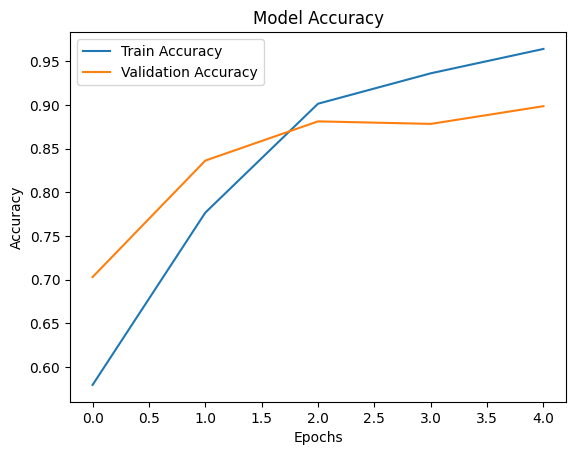

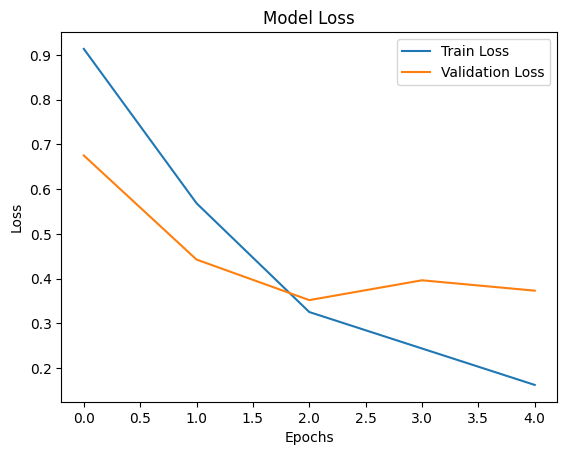

In [12]:
# Plot akurasi dan loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Mengonversi teks menjadi fitur TF-IDF untuk model Machine Learning
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df_balanced['cleaned_review']).toarray()

In [14]:
# Split data untuk model Machine Learning
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, df_balanced['sentiment'], test_size=0.2, random_state=42)

In [15]:
# Melatih model Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_ml, y_train_ml)
y_pred_lr = lr_model.predict(X_test_ml)

In [16]:
# Evaluasi model Logistic Regression
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test_ml, y_pred_lr))
print(classification_report(y_test_ml, y_pred_lr))

Logistic Regression Results
Accuracy: 0.8539976825028969
              precision    recall  f1-score   support

     negatif       0.86      0.59      0.70       192
      netral       0.85      0.94      0.89       268
     positif       0.86      0.92      0.89       403

    accuracy                           0.85       863
   macro avg       0.85      0.82      0.83       863
weighted avg       0.85      0.85      0.85       863



In [17]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
y_pred_rf = rf_model.predict(X_test_ml)

In [18]:
# Evaluasi model Random Forest
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test_ml, y_pred_rf))
print(classification_report(y_test_ml, y_pred_rf))

Random Forest Results
Accuracy: 0.8876013904982619
              precision    recall  f1-score   support

     negatif       0.84      0.73      0.78       192
      netral       0.97      0.94      0.96       268
     positif       0.86      0.93      0.89       403

    accuracy                           0.89       863
   macro avg       0.89      0.87      0.88       863
weighted avg       0.89      0.89      0.89       863



In [19]:
# Inference model deep learning
def predict_sentiment_lstm(text, model, tokenizer, max_len=100):
    # Preprocessing teks input
    cleaned_text = preprocess_text(text)

    # Tokenisasi dan padding teks input
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Prediksi sentimen
    prediction = model.predict(padded_sequence)

    # Kelas prediksi
    class_index = np.argmax(prediction, axis=1)[0]

    # Memetakan indeks kelas ke label sentimen
    sentiment_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    return sentiment_map[class_index]

In [20]:
# Inference model machine learning
def predict_sentiment_ml(text, model, tfidf_vectorizer):
    # Preprocessing teks input
    cleaned_text = preprocess_text(text)

    # Mengonversi teks menjadi fitur TF-IDF
    features = tfidf_vectorizer.transform([cleaned_text]).toarray()

    # Prediksi sentimen
    prediction = model.predict(features)

    return prediction[0]

In [21]:
# Teks yang diuji
test_text = "Aplikasi transportasi terbaik pembayaran mudah dan biaya hemat"

# Prediksi menggunakan model LSTM
predicted_sentiment_lstm = predict_sentiment_lstm(test_text, model, tokenizer)
print(f"LSTM Prediction: {predicted_sentiment_lstm}")

# Prediksi menggunakan model Logistic Regression
predicted_sentiment_lr = predict_sentiment_ml(test_text, lr_model, tfidf)
print(f"Logistic Regression Prediction: {predicted_sentiment_lr}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM Prediction: positif
Logistic Regression Prediction: positif


In [22]:
!pip freeze > requirements.txt